# Resultados simulaciones

Se revisan los resultados de las simulaciones del modelo original de Brian Arthur, barriendo los parámetros `tamaño bolsa predictores` ($k$) y `conectividad` ($p$).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Función para obtener los datos

In [23]:
def leer_datos(memorias, predictores, conectividades):
    names = ['Memoria', 'Num_predic', 'Identificador', 'Ronda', 'Agente', 'Estado', 'Puntaje', 'Politica', 'Prediccion', 'Precision']
    df_list = []
    for d in memorias:
        for k in predictores:
            for p in conectividades:
                print(f"Leyendo datos sweep memoria {d} predictores {k} y conectividad {p}")
                archivo = './data/simulacion-' + str(d) + "-" + str(k) + '-' + str(p) + ".csv"
                print(f"Cargando datos de archivo {archivo}...")
                try:
                    aux = pd.read_csv(archivo, names=names, header=None)
                    aux['Conectividad'] = p
                    df_list.append(aux)
                    print("Listo")
                except:
                    print("Archivo no existe! Saltando a siguiente opción")
    print("Preparando dataframe...")
    data = pd.concat(df_list)
    try:
        data = data.dropna()
        data['Conectividad'] = data['Conectividad'].astype(float)
        data['Memoria'] = data['Memoria'].astype(int)
        data['Num_predic'] = data['Num_predic'].astype(int)
        data['Identificador'] = data['Identificador'].astype(int)
        data['Ronda'] = data['Ronda'].astype(int)
        data['Agente'] = data['Agente'].astype(int)
        data['Estado'] = data['Estado'].astype(int)
        data['Puntaje'] = data['Puntaje'].astype(int)
        data['Politica'] = data['Politica'].astype(str)
        data['Prediccion'] = data['Prediccion'].astype(int)
        data['Precision'] = data['Precision'].astype(int)
    except:
        data = data.iloc[1:]
        data = data.dropna()
        data['Conectividad'] = data['Conectividad'].astype(float)
        data['Memoria'] = data['Memoria'].astype(int)
        data['Num_predic'] = data['Num_predic'].astype(int)
        data['Identificador'] = data['Identificador'].astype(int)
        data['Ronda'] = data['Ronda'].astype(int)
        data['Agente'] = data['Agente'].astype(int)
        data['Estado'] = data['Estado'].astype(int)
        data['Puntaje'] = data['Puntaje'].astype(int)
        data['Politica'] = data['Politica'].astype(str)
        data['Prediccion'] = data['Prediccion'].astype(int)
        data['Precision'] = data['Precision'].astype(int)
    data = data[['Conectividad','Memoria','Num_predic','Identificador','Ronda','Agente','Estado','Puntaje','Politica', 'Prediccion', 'Precision']]
    print("Shape:", data.shape)
    print("Memoria value counts:", data['Memoria'].value_counts())
    print("Predictores value counts:", data['Num_predic'].value_counts())
    print("Conectividades value counts:", data['Conectividad'].value_counts())
    print("Agente value counts:", data['Agente'].value_counts())
    return data

### Funciones para generar las gráficas

In [24]:
def dibuja_asistencia_vs(data, variable='Memoria'):
    Numero_agentes = max(data['Agente']) + 1
    aux = data.groupby([variable, 'Identificador', 'Ronda'])['Estado']\
        .sum().reset_index()
    aux.columns = [variable,
                   'Identificador',
                   'Ronda', 
                   'Asistencia_total']

    aux['Asistencia_total'] = (aux['Asistencia_total']/Numero_agentes)*100 
    rondas = aux['Ronda'].unique()
    aux1 = aux[aux['Ronda'] > rondas[-5]]
    aux1 = aux1.groupby([variable, 'Identificador'])['Asistencia_total']\
        .mean().reset_index()
    aux1.columns = [variable,
                   'Identificador',
                   'Asistencia_total']
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    for v, grp in aux.groupby(variable):
        sns.lineplot(x=grp['Ronda'], y=grp['Asistencia_total'], label=v, ax=ax[0])
    ax[0].legend().set_title(variable)
    sns.boxplot(x=aux1[variable], y=aux1['Asistencia_total'], ax=ax[1])
    ax[0].set_xlabel('Ronda')
    ax[0].set_ylabel('Asistencia promedio')
    ax[0].set_title('Asistencia promedio por ronda')
    ax[1].set_xlabel(variable)
    ax[1].set_ylabel('Asistencia últimas 5 rondas')
    ax[1].set_title('Distribución asistencia en las últimas 5 rondas')


In [53]:
def dibujar_puntaje_vs(data, variable):
    fig, ax = plt.subplots(2,1,figsize=(8,8))
    data_aux = data.groupby([variable, 'Identificador'])['Puntaje'].mean().reset_index()
    sns.boxplot(
        x=data_aux[variable], 
        y=data_aux['Puntaje'],
        ax=ax[0]
    )
    df = data.groupby([variable, 'Identificador', 'Agente'])['Puntaje'].mean().reset_index()
    for key, grp in df.groupby(variable):
        sns.distplot(grp['Puntaje'], ax=ax[1], label=key)
    ax[1].legend().set_title(variable)
    ax[0].set_ylabel('Puntaje')
    ax[0].set_title('Distribución puntaje vs ' + variable)
    ax[1].set_xlabel('Puntaje promedio')
    ax[1].set_ylabel('')
    ax[1].set_title('Distribución de la recompensa\n por cada ' + variable)
    fig.tight_layout()

In [26]:
def dibuja_usopredictores_vs(data, variable):
    df = data.groupby(variable)['Politica'].value_counts().rename_axis([variable, 'Politica']).reset_index(name='Usos')
    g = sns.FacetGrid(df, col=variable, aspect=1.5, height=4, sharex=False)
    g.map(sns.barplot, "Politica", "Usos")
    g.set_xticklabels(rotation=90)

In [27]:
def dibuja_puntajepredictor_vs(data, variable):
    data['Politica_lag'] = data.groupby([variable, 'Identificador', 'Agente'])['Politica'].transform('shift', -1)
    df = data.groupby([variable, 'Politica_lag', 'Identificador'])['Puntaje'].mean().reset_index()
    for p, Grp in df.groupby(variable):
        grp = Grp.sort_values(by='Puntaje')
        fig, ax = plt.subplots(1,1,figsize = (8,5))
        sns.swarmplot(x=grp['Politica_lag'], y=grp['Puntaje'])
        fig.suptitle(variable + ': ' + str(p), fontsize=14)
        plt.xticks(rotation=90)

In [146]:
memorias = [9]
predictores = [1]
conectividades = ['0', '0.5']
data = leer_datos(memorias, predictores, conectividades)
data['Espejo'] = [('espejo' in x) for x in data['Politica']]
data['Espejo'] = data['Espejo'].apply(lambda x: 'Sí' if x==True else 'No')
data.head()

Leyendo datos sweep memoria 9 predictores 1 y conectividad 0
Cargando datos de archivo ./data/simulacion-9-1-0.csv...
Listo
Leyendo datos sweep memoria 9 predictores 1 y conectividad 0.5
Cargando datos de archivo ./data/simulacion-9-1-0.5.csv...
Listo
Preparando dataframe...
Shape: (1980000, 11)
Memoria value counts: 9    1980000
Name: Memoria, dtype: int64
Predictores value counts: 1    1980000
Name: Num_predic, dtype: int64
Conectividades value counts: 0.5    990000
0.0    990000
Name: Conectividad, dtype: int64
Agente value counts: 99    19800
36    19800
26    19800
27    19800
28    19800
      ...  
69    19800
70    19800
71    19800
72    19800
0     19800
Name: Agente, Length: 100, dtype: int64


Conectividad  Memoria  Num_predic  Identificador  Ronda  Agente  Estado  \
1           0.0        9           1           6600      1       0       1   
2           0.0        9           1           6600      2       0       1   
3           0.0        9           1           6600      3       0       1   
4           0.0        9           1           6600      4       0       1   
5           0.0        9           1           6600      5       0       1   

   Puntaje          Politica  Prediccion  Precision Espejo  
1       -1  4-ciclico-espejo           0         51     Sí  
2       -1  4-ciclico-espejo          38         56     Sí  
3       -1  4-ciclico-espejo          38         45     Sí  
4       -1  4-ciclico-espejo          44         40     Sí  
5       -1  4-ciclico-espejo          19         36     Sí

In [147]:
df1 = data[data['Conectividad']==0]
df2 = data[data['Conectividad']==0.5]


In [148]:
dfA = df1.groupby('Politica').agg({'Precision':'mean', 'Puntaje':'mean'}).reset_index()
dfA['Espejo'] = [('espejo' not in x) for x in dfA['Politica']]
dfA['Espejo'] = dfA['Espejo'].apply(lambda x: 'No' if x==True else 'Sí')
dfA.head()

Politica  Precision   Puntaje Espejo
0         1-ciclico  15.480450 -0.080890     No
1  1-ciclico-espejo  27.252247 -0.035528     Sí
2         1-ventana  28.611328 -0.496685     No
3  1-ventana-espejo  28.635982 -0.080713     Sí
4        10-ciclico  26.789414 -0.479596     No

In [149]:
dfB = df2.groupby('Politica').agg({'Precision':'mean', 'Puntaje':'mean'}).reset_index()
dfB['Espejo'] = [('espejo' in x) for x in dfA['Politica']]
dfB['Espejo'] = dfB['Espejo'].apply(lambda x: 'Sí' if x==True else 'No')
dfB.head()

Politica  Precision   Puntaje Espejo
0         1-ciclico  44.630040 -0.508140     No
1  1-ciclico-espejo  89.108054 -0.858358     Sí
2         1-ventana  90.250547 -0.681619     No
3  1-ventana-espejo  26.748420 -0.048040     Sí
4        10-ciclico  81.168893 -0.427850     No

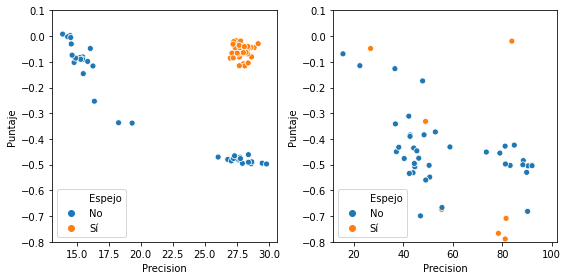

In [150]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.scatterplot(x='Precision', y='Puntaje', hue='Espejo', data=dfA, ax=ax[0])
sns.scatterplot(x='Precision', y='Puntaje', hue='Espejo', data=dfB, ax=ax[1])
ax[0].set(ylim=(-0.8, 0.1))
ax[1].set(ylim=(-0.8, 0.1))
fig.tight_layout()


/usr/local/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


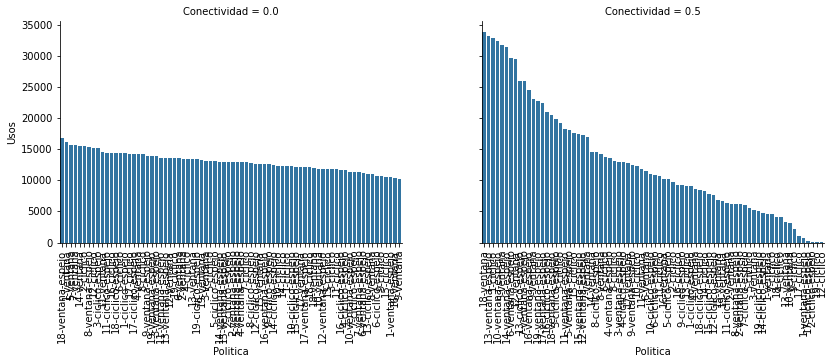

In [151]:
dibuja_usopredictores_vs(data, 'Conectividad')

In [152]:
df_uso = df2.groupby(['Ronda', 'Espejo'])['Politica'].count().reset_index(name='Uso')
df_uso.head()

Ronda Espejo   Uso
0      1     No  4867
1      1     Sí  5133
2      2     No  4675
3      2     Sí  5325
4      3     No  4449

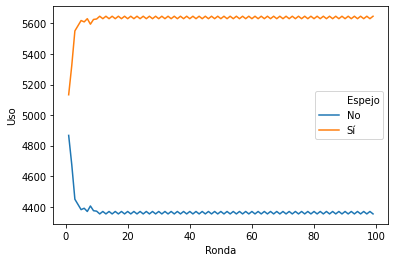

In [153]:
sns.lineplot(x='Ronda', y='Uso', hue='Espejo', data=df_uso)

Si $p>\frac{\ln(n)}{n-1}$, el grafo es conectado

$n=100$, $\frac{\ln(100)}{99}\approx 0.046$

## Simulaciones con 1 predictor variando conectividad:

**Obtener datos**

In [28]:
memorias = [9]
predictores = [1]
conectividades = ['0', '0.004', '0.006', '0.008', '0.01', '0.012', '0.03']
data = leer_datos(memorias, predictores, conectividades)
data.head()

Leyendo datos sweep memoria 9 predictores 1 y conectividad 0
Cargando datos de archivo ./data/simulacion-9-1-0.csv...
Listo
Leyendo datos sweep memoria 9 predictores 1 y conectividad 0.004
Cargando datos de archivo ./data/simulacion-9-1-0.004.csv...
Listo
Leyendo datos sweep memoria 9 predictores 1 y conectividad 0.006
Cargando datos de archivo ./data/simulacion-9-1-0.006.csv...
Listo
Leyendo datos sweep memoria 9 predictores 1 y conectividad 0.008
Cargando datos de archivo ./data/simulacion-9-1-0.008.csv...
Listo
Leyendo datos sweep memoria 9 predictores 1 y conectividad 0.01
Cargando datos de archivo ./data/simulacion-9-1-0.01.csv...
Listo
Leyendo datos sweep memoria 9 predictores 1 y conectividad 0.012
Cargando datos de archivo ./data/simulacion-9-1-0.012.csv...
Listo
Leyendo datos sweep memoria 9 predictores 1 y conectividad 0.03
Cargando datos de archivo ./data/simulacion-9-1-0.03.csv...
Listo
Preparando dataframe...
Shape: (6930000, 11)
Memoria value counts: 9    6930000
Name: Me

Conectividad  Memoria  Num_predic  Identificador  Ronda  Agente  Estado  \
1           0.0        9           1           6600      1       0       1   
2           0.0        9           1           6600      2       0       1   
3           0.0        9           1           6600      3       0       1   
4           0.0        9           1           6600      4       0       1   
5           0.0        9           1           6600      5       0       1   

   Puntaje          Politica  Prediccion  Precision  
1       -1  4-ciclico-espejo           0         51  
2       -1  4-ciclico-espejo          38         56  
3       -1  4-ciclico-espejo          38         45  
4       -1  4-ciclico-espejo          44         40  
5       -1  4-ciclico-espejo          19         36

**Asistencia**

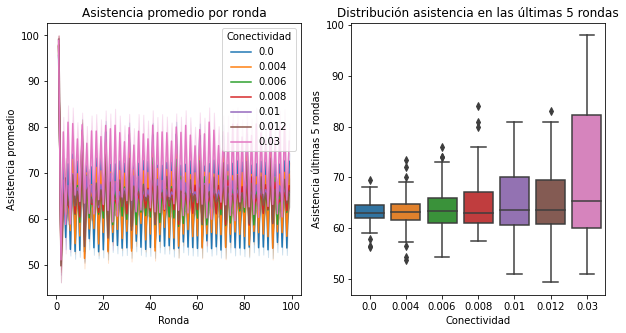

In [29]:
dibuja_asistencia_vs(data, 'Conectividad')

#### Recompensa total

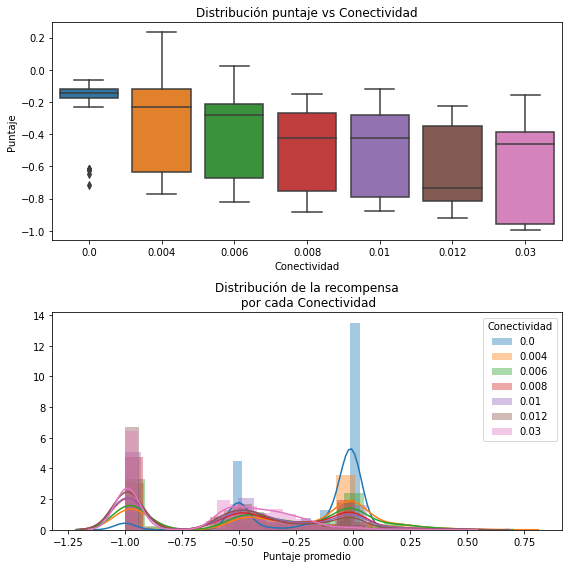

In [54]:
dibujar_puntaje_vs(data, 'Conectividad')

**Uso de políticas**

/usr/local/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


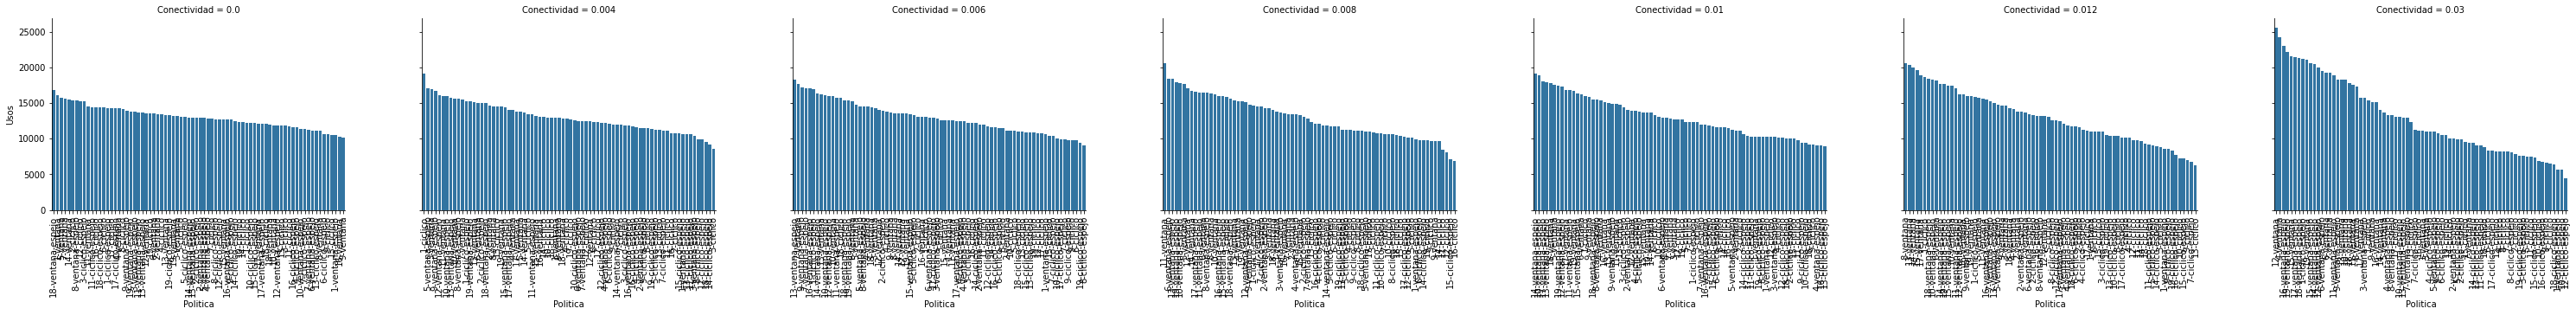

In [31]:
dibuja_usopredictores_vs(data, 'Conectividad')

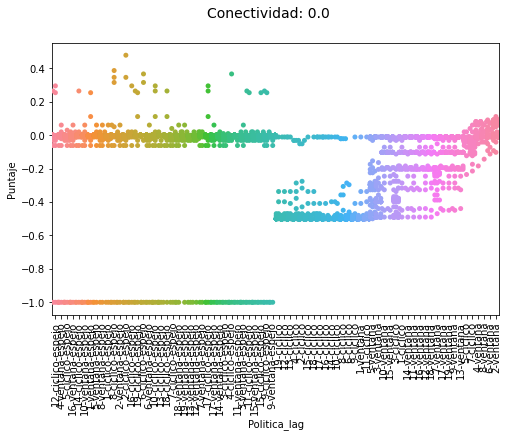

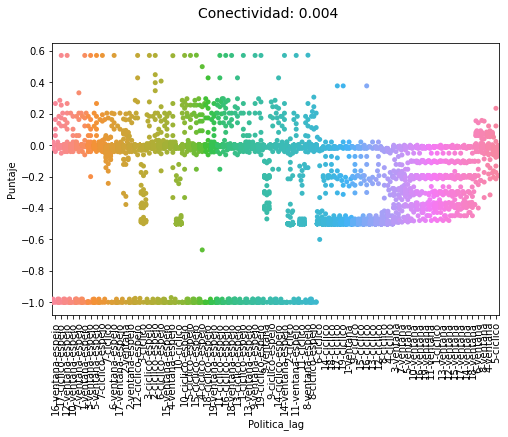

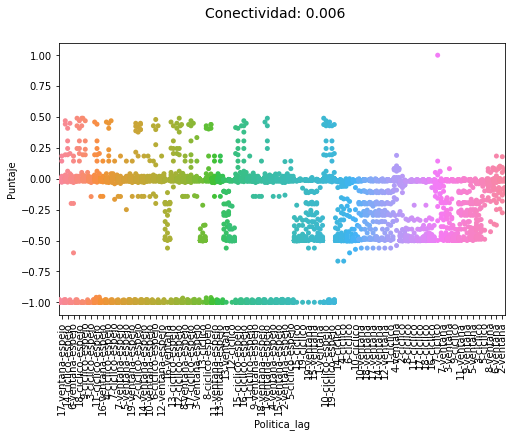

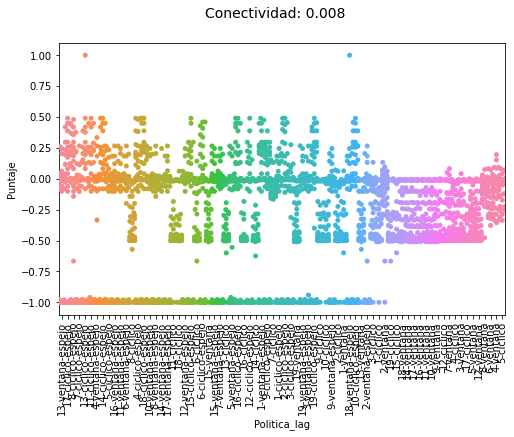

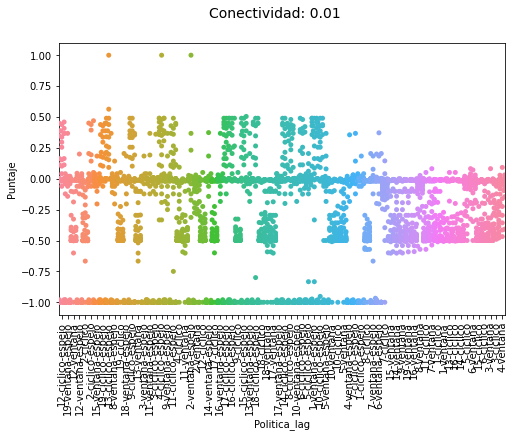

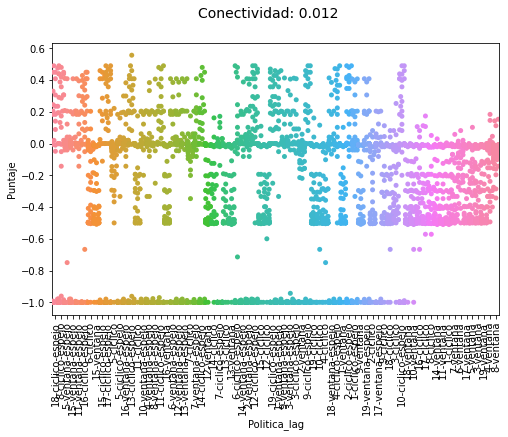

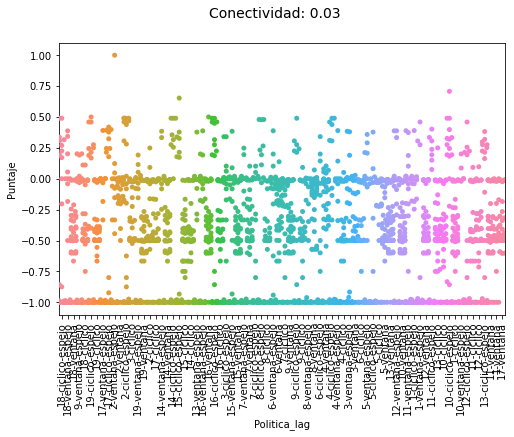

In [33]:
dibuja_puntajepredictor_vs(data, 'Conectividad')

## Simulaciones con 3 predictores variando conectividad:

**Obtener datos**

In [58]:
memorias = [9]
predictores = [3]
conectividades = ['0', '0.004', '0.006', '0.008', '0.01', '0.012', '0.03']
data = leer_datos(memorias, predictores, conectividades)
data.head()

Leyendo datos sweep memoria 9 predictores 3 y conectividad 0
Cargando datos de archivo ./data/simulacion-9-3-0.csv...
Listo
Leyendo datos sweep memoria 9 predictores 3 y conectividad 0.004
Cargando datos de archivo ./data/simulacion-9-3-0.004.csv...
Listo
Leyendo datos sweep memoria 9 predictores 3 y conectividad 0.006
Cargando datos de archivo ./data/simulacion-9-3-0.006.csv...
Listo
Leyendo datos sweep memoria 9 predictores 3 y conectividad 0.008
Cargando datos de archivo ./data/simulacion-9-3-0.008.csv...
Listo
Leyendo datos sweep memoria 9 predictores 3 y conectividad 0.01
Cargando datos de archivo ./data/simulacion-9-3-0.01.csv...
Listo
Leyendo datos sweep memoria 9 predictores 3 y conectividad 0.012
Cargando datos de archivo ./data/simulacion-9-3-0.012.csv...
Listo
Leyendo datos sweep memoria 9 predictores 3 y conectividad 0.03
Cargando datos de archivo ./data/simulacion-9-3-0.03.csv...
Listo
Preparando dataframe...
Shape: (6930000, 11)
Memoria value counts: 9    6930000
Name: Me

Conectividad  Memoria  Num_predic  Identificador  Ronda  Agente  Estado  \
1           0.0        9           3           7700      1       0       1   
2           0.0        9           3           7700      2       0       1   
3           0.0        9           3           7700      3       0       1   
4           0.0        9           3           7700      4       0       1   
5           0.0        9           3           7700      5       0       1   

   Puntaje          Politica  Prediccion  Precision  
1       -1  5-ventana-espejo          22         57  
2        1  5-ventana-espejo          32         42  
3       -1  5-ventana-espejo          32         40  
4        1  5-ventana-espejo          36         34  
5       -1  5-ventana-espejo          33         34

**Asistencia**

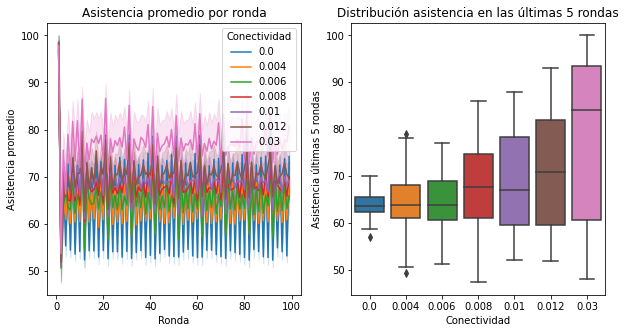

In [35]:
dibuja_asistencia_vs(data, 'Conectividad')

#### Recompensa total

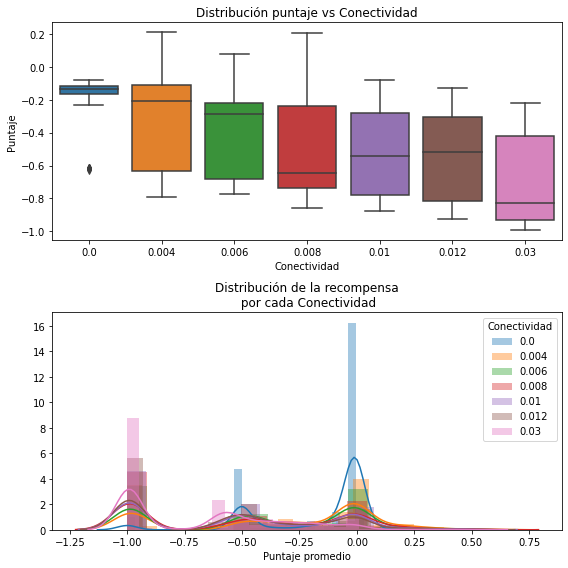

In [59]:
dibujar_puntaje_vs(data, 'Conectividad')

**Uso de políticas**

/usr/local/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


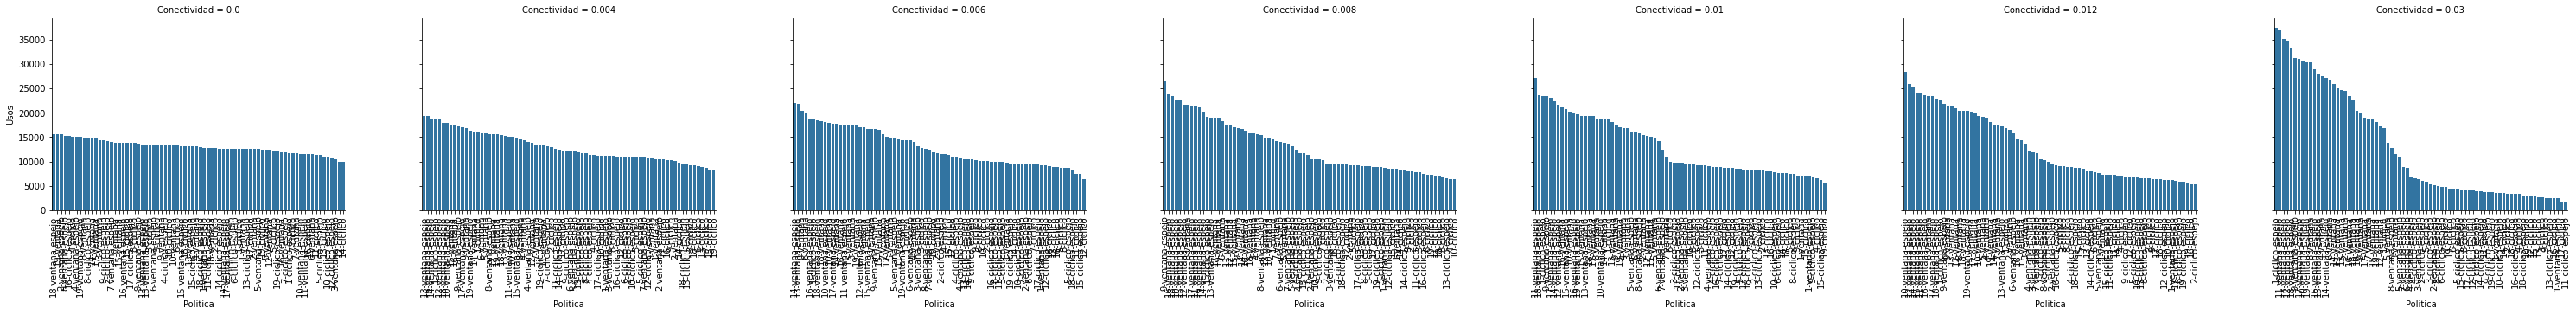

In [37]:
dibuja_usopredictores_vs(data, 'Conectividad')

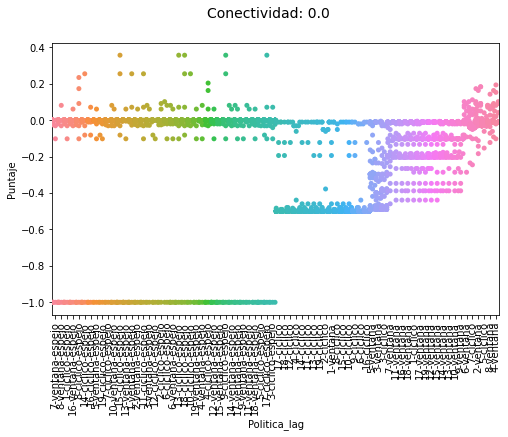

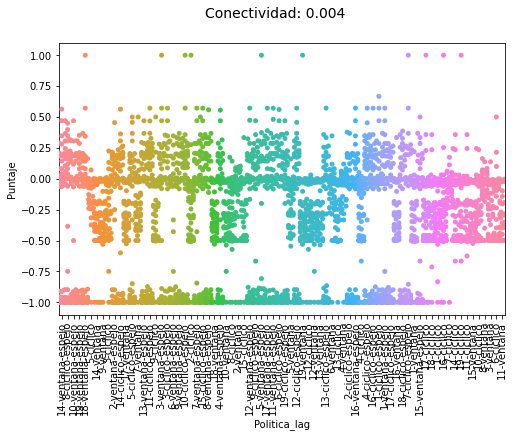

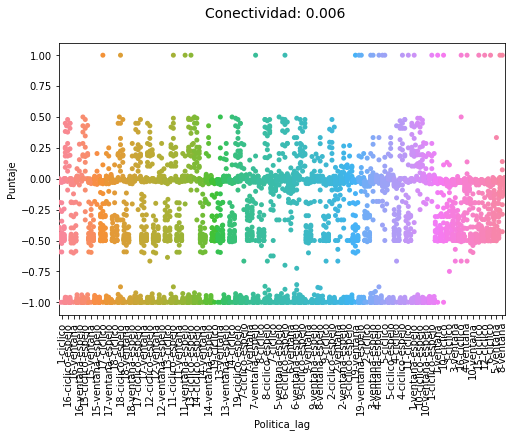

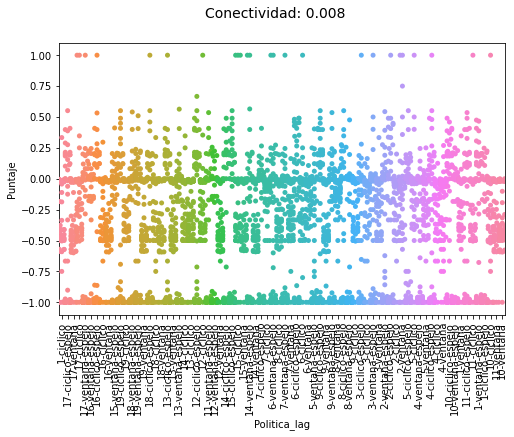

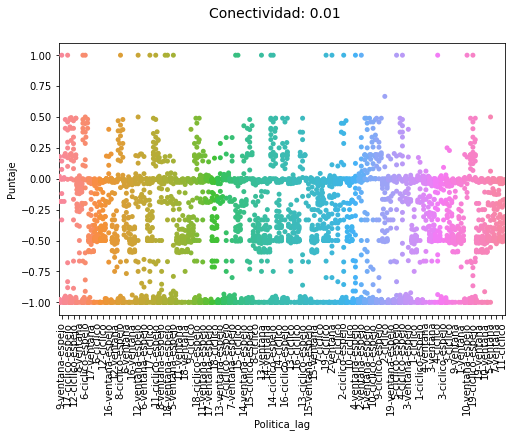

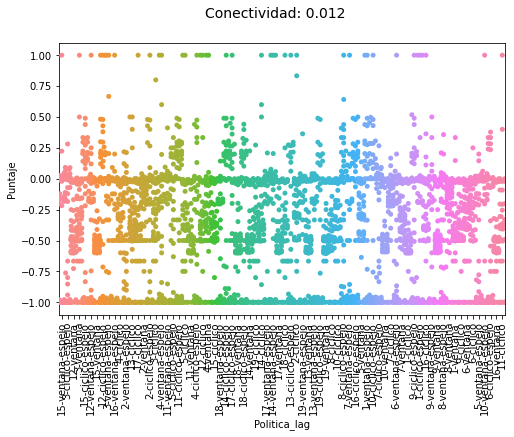

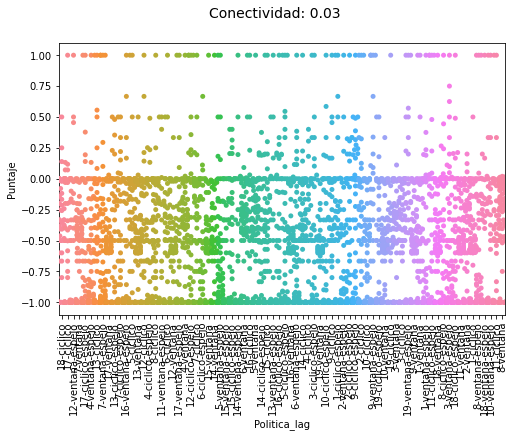

In [38]:
dibuja_puntajepredictor_vs(data, 'Conectividad')

## Simulaciones con 6 predictores variando conectividad:

**Obtener datos**

In [39]:
memorias = [9]
predictores = [6]
conectividades = ['0', '0.004', '0.006', '0.008', '0.01', '0.012', '0.03']
data = leer_datos(memorias, predictores, conectividades)
data.head()

Leyendo datos sweep memoria 9 predictores 6 y conectividad 0
Cargando datos de archivo ./data/simulacion-9-6-0.csv...
Listo
Leyendo datos sweep memoria 9 predictores 6 y conectividad 0.004
Cargando datos de archivo ./data/simulacion-9-6-0.004.csv...
Listo
Leyendo datos sweep memoria 9 predictores 6 y conectividad 0.006
Cargando datos de archivo ./data/simulacion-9-6-0.006.csv...
Listo
Leyendo datos sweep memoria 9 predictores 6 y conectividad 0.008
Cargando datos de archivo ./data/simulacion-9-6-0.008.csv...
Listo
Leyendo datos sweep memoria 9 predictores 6 y conectividad 0.01
Cargando datos de archivo ./data/simulacion-9-6-0.01.csv...
Listo
Leyendo datos sweep memoria 9 predictores 6 y conectividad 0.012
Cargando datos de archivo ./data/simulacion-9-6-0.012.csv...
Listo
Leyendo datos sweep memoria 9 predictores 6 y conectividad 0.03
Cargando datos de archivo ./data/simulacion-9-6-0.03.csv...
Listo
Preparando dataframe...
Shape: (6930000, 11)
Memoria value counts: 9    6930000
Name: Me

Conectividad  Memoria  Num_predic  Identificador  Ronda  Agente  Estado  \
1           0.0        9           6           8800      1       0       1   
2           0.0        9           6           8800      2       0       0   
3           0.0        9           6           8800      3       0       1   
4           0.0        9           6           8800      4       0       0   
5           0.0        9           6           8800      5       0       1   

   Puntaje    Politica  Prediccion  Precision  
1       -1  10-ciclico         100         50  
2        0  10-ciclico          50         50  
3       -1  10-ciclico          70         40  
4        0  10-ciclico          52         34  
5       -1  10-ciclico          72         31

**Asistencia**

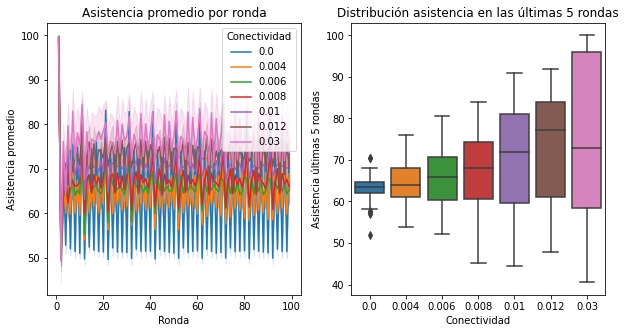

In [40]:
dibuja_asistencia_vs(data, 'Conectividad')

#### Recompensa total

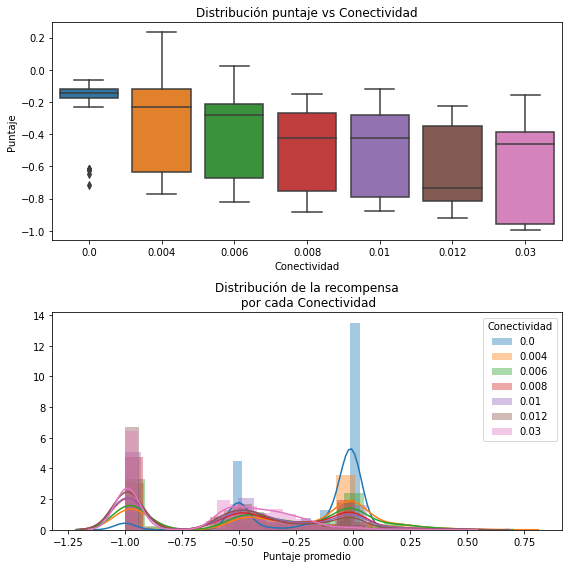

In [56]:
dibujar_puntaje_vs(data, 'Conectividad')

**Uso de políticas**

/usr/local/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


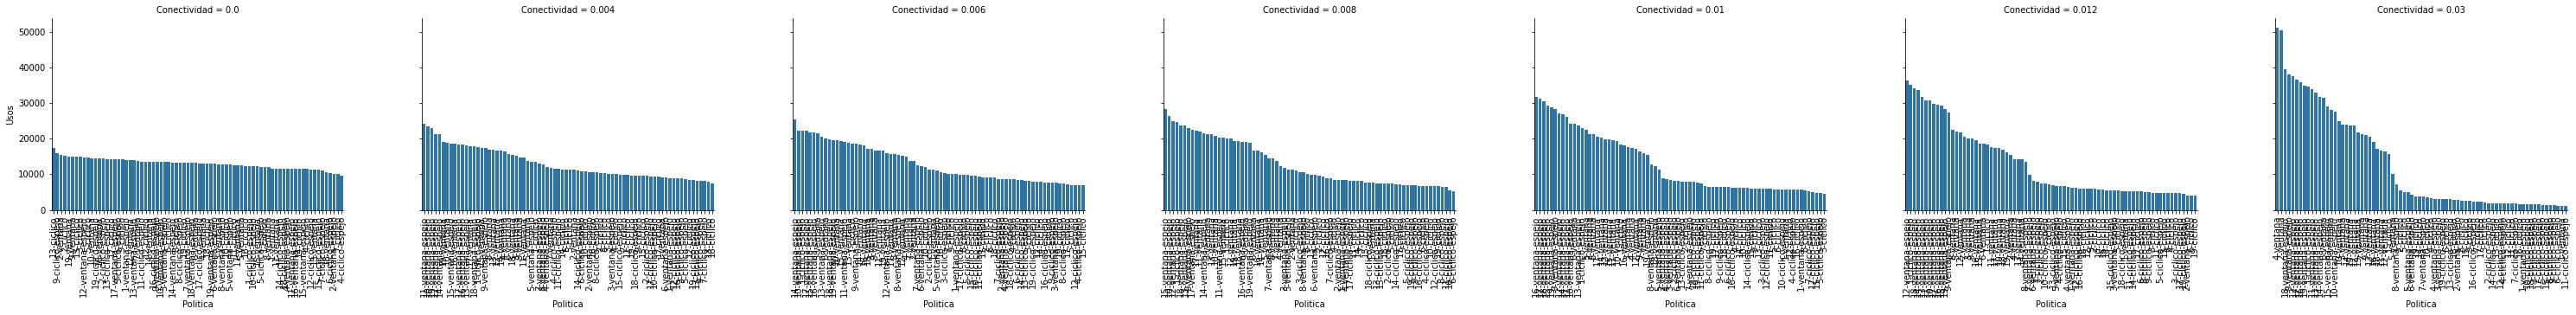

In [42]:
dibuja_usopredictores_vs(data, 'Conectividad')

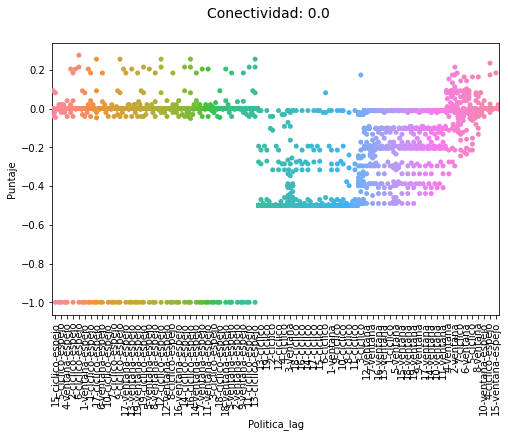

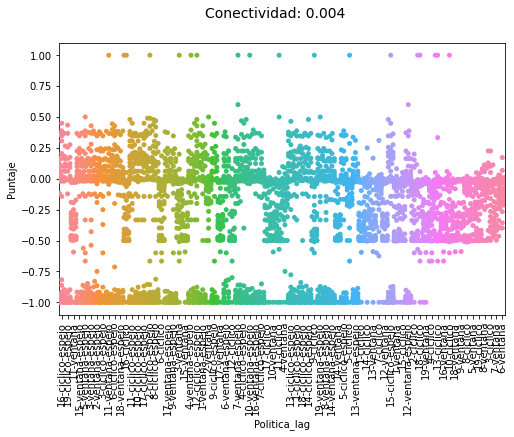

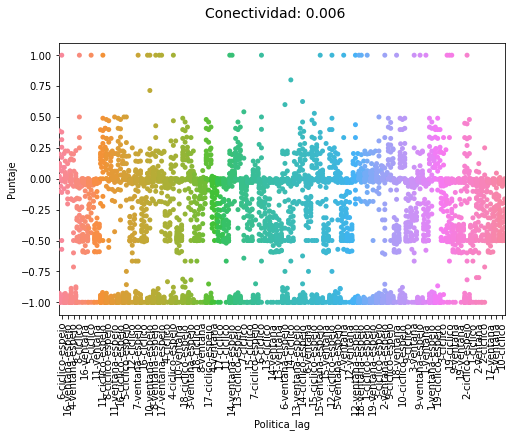

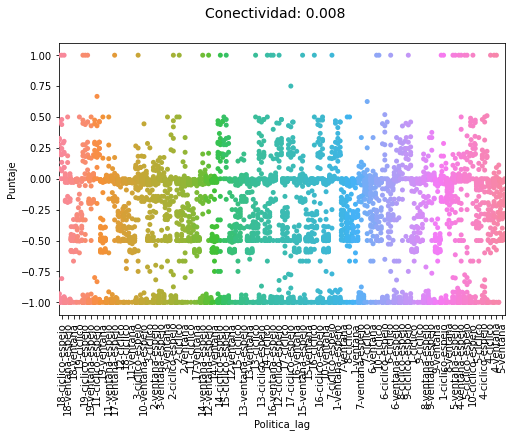

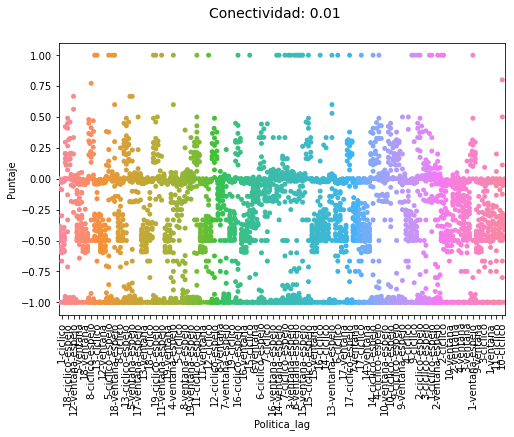

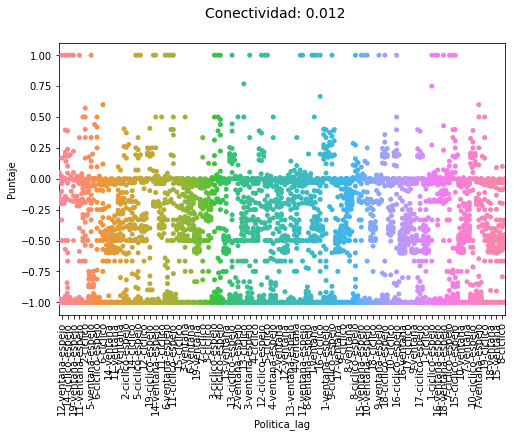

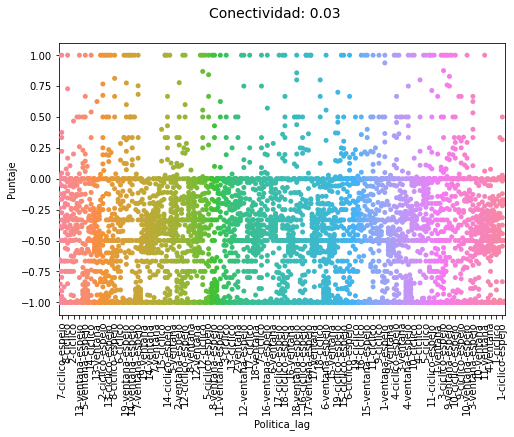

In [43]:
dibuja_puntajepredictor_vs(data, 'Conectividad')

## Simulaciones con 9 predictores variando conectividad:

**Obtener datos**

In [44]:
memorias = [9]
predictores = [9]
conectividades = ['0', '0.004', '0.006', '0.008', '0.01', '0.012', '0.03']
data = leer_datos(memorias, predictores, conectividades)
data.head()

Leyendo datos sweep memoria 9 predictores 9 y conectividad 0
Cargando datos de archivo ./data/simulacion-9-9-0.csv...
Listo
Leyendo datos sweep memoria 9 predictores 9 y conectividad 0.004
Cargando datos de archivo ./data/simulacion-9-9-0.004.csv...
Listo
Leyendo datos sweep memoria 9 predictores 9 y conectividad 0.006
Cargando datos de archivo ./data/simulacion-9-9-0.006.csv...
Listo
Leyendo datos sweep memoria 9 predictores 9 y conectividad 0.008
Cargando datos de archivo ./data/simulacion-9-9-0.008.csv...
Listo
Leyendo datos sweep memoria 9 predictores 9 y conectividad 0.01
Cargando datos de archivo ./data/simulacion-9-9-0.01.csv...
Listo
Leyendo datos sweep memoria 9 predictores 9 y conectividad 0.012
Cargando datos de archivo ./data/simulacion-9-9-0.012.csv...
Listo
Leyendo datos sweep memoria 9 predictores 9 y conectividad 0.03
Cargando datos de archivo ./data/simulacion-9-9-0.03.csv...
Listo
Preparando dataframe...
Shape: (6930000, 11)
Memoria value counts: 9    6930000
Name: Me

Conectividad  Memoria  Num_predic  Identificador  Ronda  Agente  Estado  \
1           0.0        9           9           9900      1       0       1   
2           0.0        9           9           9900      2       0       0   
3           0.0        9           9           9900      3       0       1   
4           0.0        9           9           9900      4       0       0   
5           0.0        9           9           9900      5       0       0   

   Puntaje   Politica  Prediccion  Precision  
1       -1  3-ciclico         100         49  
2        0  3-ciclico          57         46  
3       -1  3-ciclico          62         36  
4        0  3-ciclico          78         28  
5        0  3-ciclico          63         24

**Asistencia**

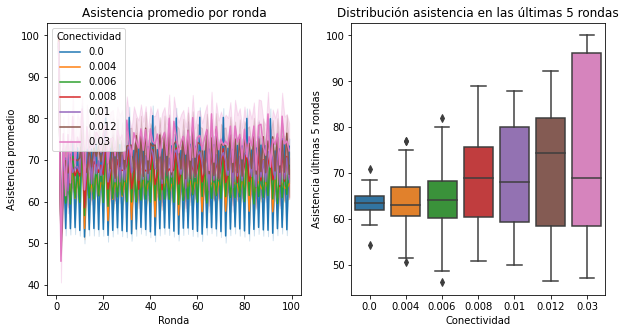

In [45]:
dibuja_asistencia_vs(data, 'Conectividad')

#### Recompensa total

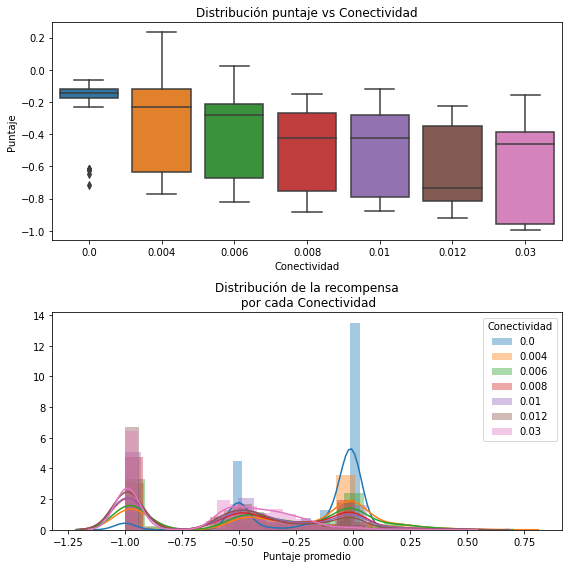

In [57]:
dibujar_puntaje_vs(data, 'Conectividad')

**Uso de políticas**

/usr/local/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


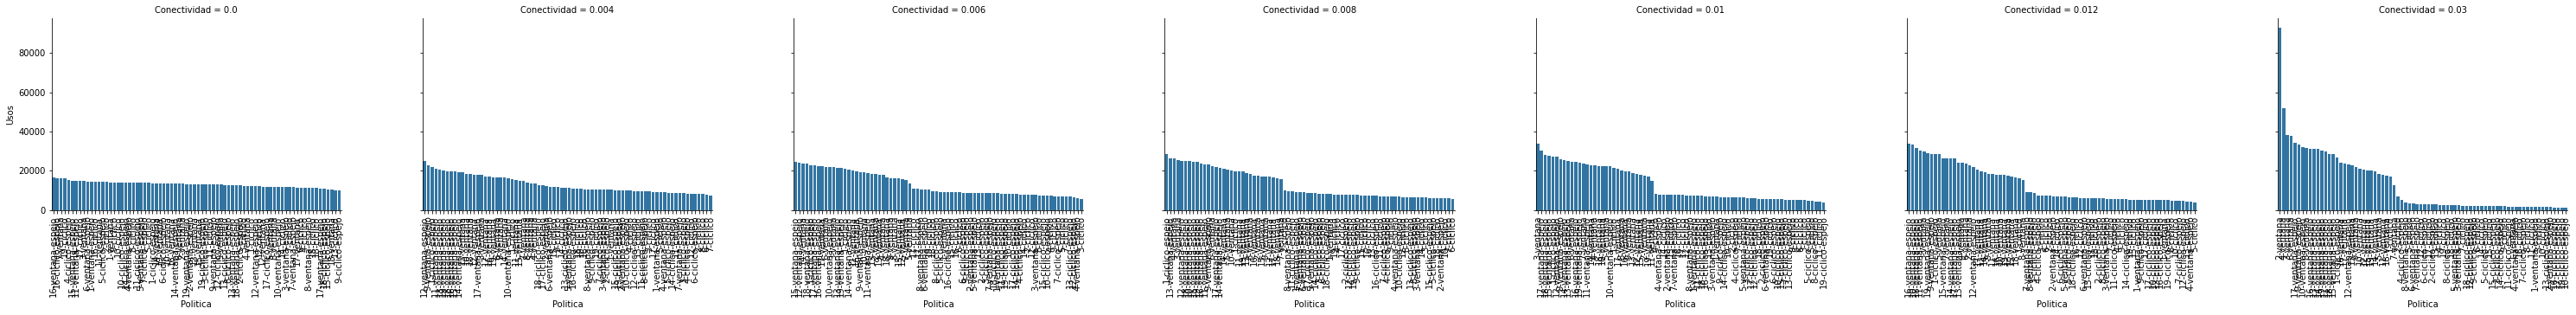

In [47]:
dibuja_usopredictores_vs(data, 'Conectividad')

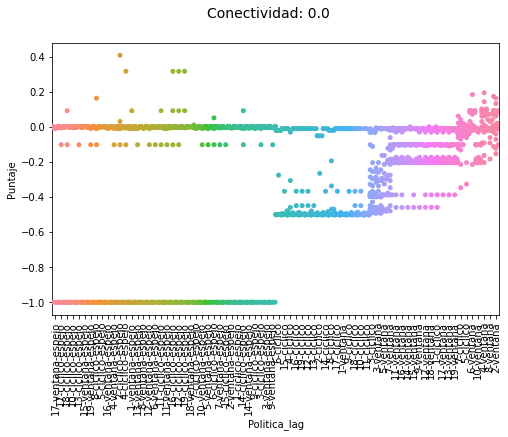

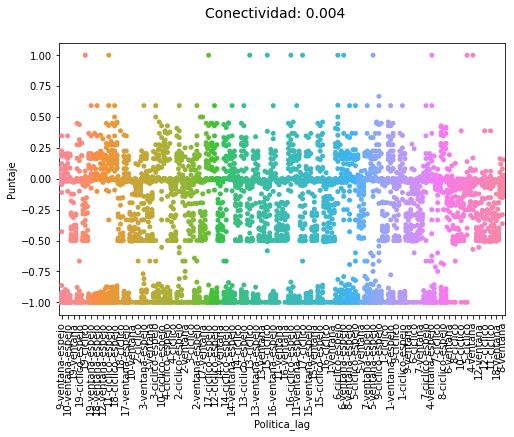

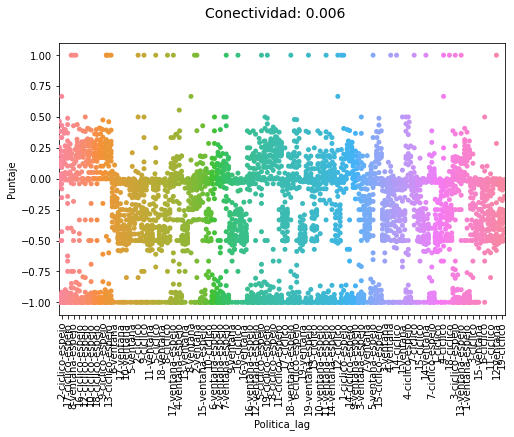

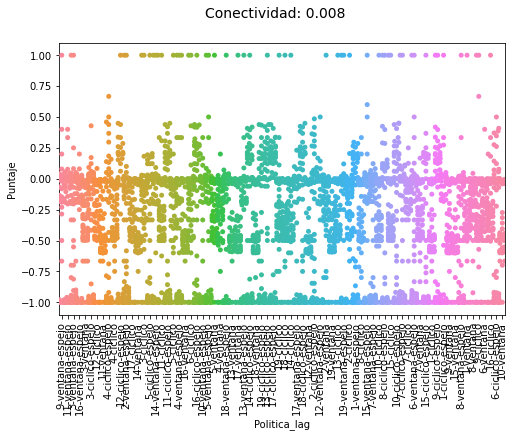

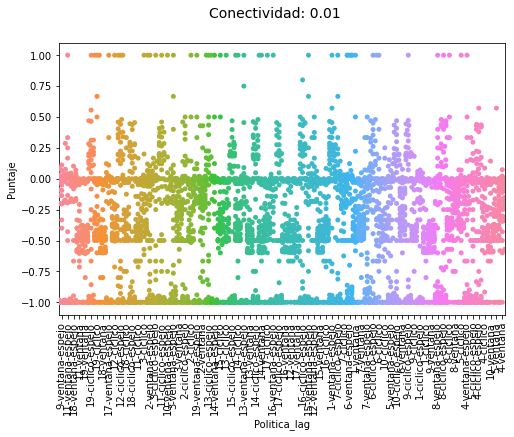

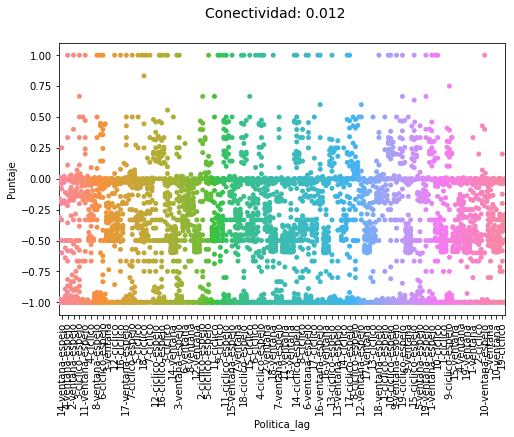

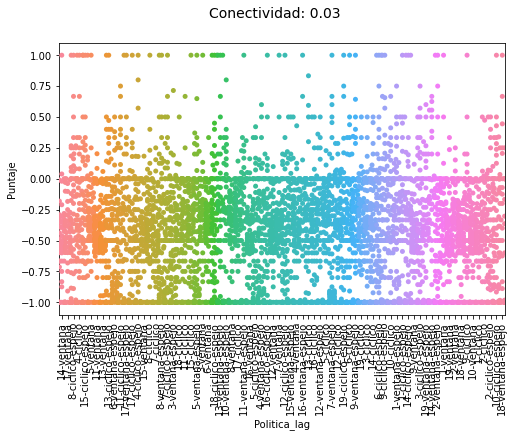

In [48]:
dibuja_puntajepredictor_vs(data, 'Conectividad')